In [97]:
import pandas as pd 
import os
import math
import random

import numpy as np
from scipy import optimize, signal

import matplotlib.pyplot as plt
import seaborn as sns

from itertools import compress

In [99]:
from lmfit import models

### 1. Fit curve 

-----

tutorial from : 
https://chrisostrouchov.com/post/peak_fit_xrd_python/

gaussian function 

$f(x;A,\mu ,\sigma) = \frac{A}{\sigma \sqrt{2\pi}} e^{[{-(x-\sigma)^2/2\sigma^2}]}$

In [114]:
def g(x, A, mu, sigma):
    return A / (sigma * np.sqrt(2*np.pi)) * np.exp((-(x-mu)**2)/(2*sigma**2))

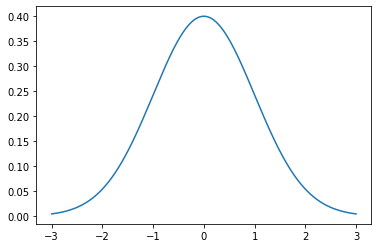

In [207]:
x = np.linspace(-3,3,1000)

y = g(x, 1, 0 ,1)

plt.plot(x,y)

Optimization of some $f(x)$

In [208]:
def f(x):
    return np.exp(-(x-2)**2) + np.exp(-(x-6)**2/10) + 1/(x**2 + 1)

x = np.linspace(-2, 10, 1000)
y = -f(x)

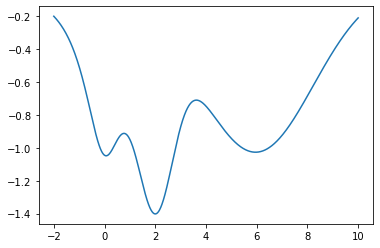

In [209]:
plt.plot(x,y)

In [210]:
res = optimize.minimize(lambda x: -f(x), x0=20, method='Nelder-Mead')

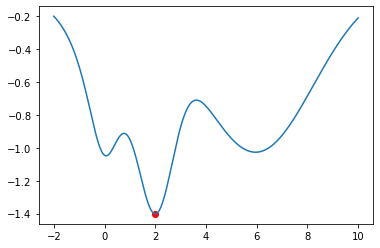

In [211]:
plt.plot(x,y)
plt.scatter(res.x, -f(res.x),c='r')

Adding noise to gaussian 

In [212]:
A=100
mu = 4
sigma = 4
n = 200

x = np.linspace(-10,10,n)
y = g(x, A, mu, sigma) + np.random.normal(0,1,n)

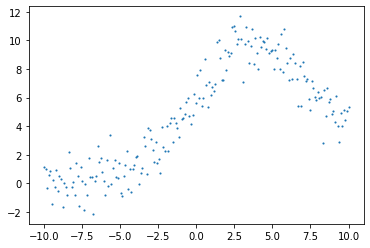

In [213]:
plt.scatter(x,y, s=1.2)

Minimize error

$MSE = \frac{1}{n} \sum_{i=1}^{n}(Y_i-\hat{Y}_i)^2$

In [214]:
def mse(params, x, y_hat):
    y = g(x,*params)
    return 1/len(y) * np.sum((y-y_hat)**2)


result = optimize.minimize(mse, x0=[0,0,1],args=(x,y), method='SLSQP')

In [215]:
print('steps', result.nit, result.fun)
print(f'amplitude: {result.x[0]:3.3f} mean: {result.x[1]:3.3f} sigma: {result.x[2]:3.3f}')

steps 13 1.1607082072556676
amplitude: 100.021 mean: 4.035 sigma: 4.090


In [218]:
y_opt = g(x, *result.x)

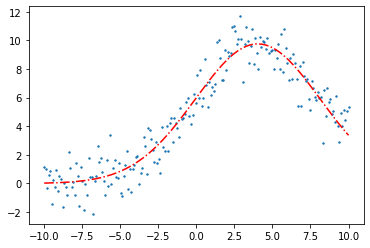

In [219]:
plt.scatter(x,y,s=2)
plt.plot(x,y_opt, '-.r')

fit two gaussian models

In [220]:
g_0 = [250.0, 4.0, 5.0]
g_1 = [20.0, -5.0, 1.0]
n = 150
x = np.linspace(-10, 10, n)

y = g(x, *g_0) + g(x, *g_1) + np.random.randn(n)

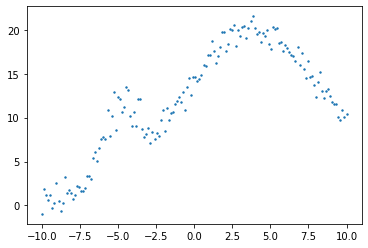

In [221]:
plt.scatter(x,y,s=2)

In [222]:
def mse(params, x, y_hat):
    y_1 = g(x,*params[:3])
    y_2 = g(x,*params[3:])
    return 1/len(y) * np.sum(((y_1+y_2)-y_hat)**2)


result = optimize.minimize(mse, x0=[1, 0, 1, -1, 0, 1],args=(x,y))

In [223]:
print('steps', result.nit, result.fun)
print(f'g_0: amplitude: {result.x[0]:3.3f} mean: {result.x[1]:3.3f} sigma: {result.x[2]:3.3f}')
print(f'g_1: amplitude: {result.x[3]:3.3f} mean: {result.x[4]:3.3f} sigma: {result.x[5]:3.3f}')



steps 48 0.9542457865014708
g_0: amplitude: 21.602 mean: -4.992 sigma: 1.086
g_1: amplitude: 244.663 mean: 3.963 sigma: 4.883


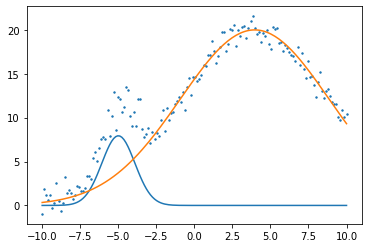

In [224]:
y_1 = g(x, *result.x[:3])
y_2 = g(x, *result.x[3:])
plt.scatter(x,y,s=2)
plt.plot(x,y_1)
plt.plot(x,y_2)

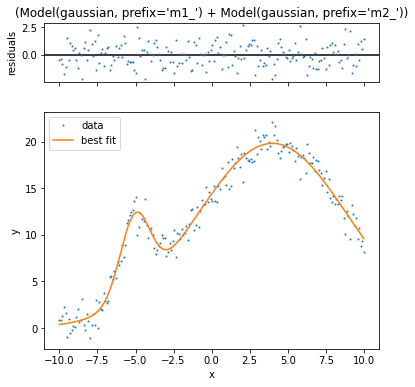

In [225]:
g_0 = [250.0, 4.0, 5.0]
g_1 = [20.0, -5.0, 1.0]
n = 200
x = np.linspace(-10, 10, n)

y = g(x, *g_0) + g(x, *g_1) + np.random.randn(n)

model_1 = models.GaussianModel(prefix='m1_')
model_2 = models.GaussianModel(prefix='m2_')
model = model_1 + model_2

params_1 = model_1.make_params(center=1, sigma=1)
params_2 = model_2.make_params(center=-2, sigma=1)
params = params_1.update(params_2)

output = model.fit(y, params, x=x)
fig = output.plot(data_kws={'markersize': 1})



### 2. Read dataset of XRD

In [226]:
dirname = '../data/QSAR_XRD/'
files = os.listdir(dirname)

# read UXD
fname = os.path.join(dirname, files[0])
with open(fname, 'rb') as file:
    data = file.readlines()

In [227]:
fname

'../data/QSAR_XRD/Fe-кирг-2.UXD'

In [228]:
class XRD_parser:
    def __init__(self):
        self.get_extension = lambda x: os.path.splitext(x)[-1]
        self.availabel_extensions = {'.UXD', '.dat', '.txt', '.xyd'}
    def _is_float(self, element: any)-> bool:
        try:
            element = element.decode('utf-8').strip().split()[0]
        except:
            return False
        if element is None:
            return False
        try: 
            float(element)
            return True
        except ValueError:
            return False

    def _convert_to_float(self, element:str)->list:
        try:
            element = element.decode('utf-8').strip().split()
            return [float(value) for value in element ]
        except ValueError:
            return []
        
    
    def parse(self, fname:str)->list:
        with open(fname, 'rb') as file:
            data = file.readlines()
        mask = list(map(is_float, data))
        selection = list(compress(data, mask))
        xrd_data = list(map(convert_to_float, selection))
        return xrd_data

In [229]:
parser = XRD_parser()

In [230]:

for file in files:
    fname = os.path.join(dirname, file)
    
    data = parser.parse(fname=fname)
    df = pd.DataFrame(data)
#     sns.lineplot(x=0, y=1, data=df)

In [231]:

data = parser.parse(fname=fname)

In [235]:
df = pd.DataFrame(data, columns=['x','y'])

In [261]:
# savgol filtering
df.loc[:, 'savgol'] = signal.savgol_filter(df.y, 15,1)

### 2. Plot XRD data

<AxesSubplot:xlabel='x', ylabel='y'>

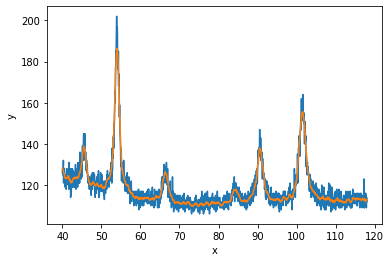

In [260]:

sns.lineplot(x='x', y='y', data=df)
sns.lineplot(x='x', y='savgol', data=df)
